In [26]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

🎯 Goal
Develop a model that predicts gold recovery at two key process stages:

1) Rougher concentrate recovery — rougher.output.recovery

2) Final concentrate recovery — final.output.recovery

You’ll use industrial process data to build models that estimate how efficiently gold is extracted at these two points.

In [27]:
gold_recovery_full = pd.read_csv('gold_recovery_full.csv')
gold_recovery_test = pd.read_csv('gold_recovery_test.csv')
gold_recovery_train = pd.read_csv('gold_recovery_train.csv')

In [28]:
display(gold_recovery_train.head(3))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

df = gold_recovery_train.copy()

cols_needed = [
    'rougher.output.recovery',
    'rougher.output.concentrate_au',
    'rougher.input.feed_au',
    'rougher.output.tail_au'
]

df = df[cols_needed].dropna()

C = df['rougher.output.concentrate_au']
F = df['rougher.input.feed_au']
T = df['rougher.output.tail_au']

recovery_calc = (C * (F - T)) / (F * (C - T)) * 100

actual_recovery = df['rougher.output.recovery']
mae = mean_absolute_error(actual_recovery, recovery_calc)

print(f"MAE between actual and calculated rougher recovery: {mae:.6f}")


MAE between actual and calculated rougher recovery: 0.000000


In [30]:
train_features = set(gold_recovery_train.columns)
test_features = set(gold_recovery_test.columns)

missing_features = sorted(list(train_features - test_features))
print(f"Missing columns in test set ({len(missing_features)}):\n")
for feature in missing_features:
    print(f"- {feature} ({gold_recovery_train[feature].dtype})")


Missing columns in test set (34):

- final.output.concentrate_ag (float64)
- final.output.concentrate_au (float64)
- final.output.concentrate_pb (float64)
- final.output.concentrate_sol (float64)
- final.output.recovery (float64)
- final.output.tail_ag (float64)
- final.output.tail_au (float64)
- final.output.tail_pb (float64)
- final.output.tail_sol (float64)
- primary_cleaner.output.concentrate_ag (float64)
- primary_cleaner.output.concentrate_au (float64)
- primary_cleaner.output.concentrate_pb (float64)
- primary_cleaner.output.concentrate_sol (float64)
- primary_cleaner.output.tail_ag (float64)
- primary_cleaner.output.tail_au (float64)
- primary_cleaner.output.tail_pb (float64)
- primary_cleaner.output.tail_sol (float64)
- rougher.calculation.au_pb_ratio (float64)
- rougher.calculation.floatbank10_sulfate_to_au_feed (float64)
- rougher.calculation.floatbank11_sulfate_to_au_feed (float64)
- rougher.calculation.sulfate_to_au_concentrate (float64)
- rougher.output.concentrate_ag (fl

### 1.4

In [ ]:
for df in [gold_recovery_train, gold_recovery_test, gold_recovery_full]:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

target_columns = ['rougher.output.recovery', 'final.output.recovery']
shared_feature_columns = gold_recovery_train.columns.intersection(gold_recovery_test.columns)

train_features = gold_recovery_train[shared_feature_columns].copy()
train_target = gold_recovery_train[target_columns].copy()
test_features = gold_recovery_test[shared_feature_columns].copy()

train_features = train_features.ffill()
test_features = test_features.ffill()
train_target = train_target.ffill()

train_features.sort_index(inplace=True)
test_features.sort_index(inplace=True)
train_target.sort_index(inplace=True)

print("Finished preprocessing")

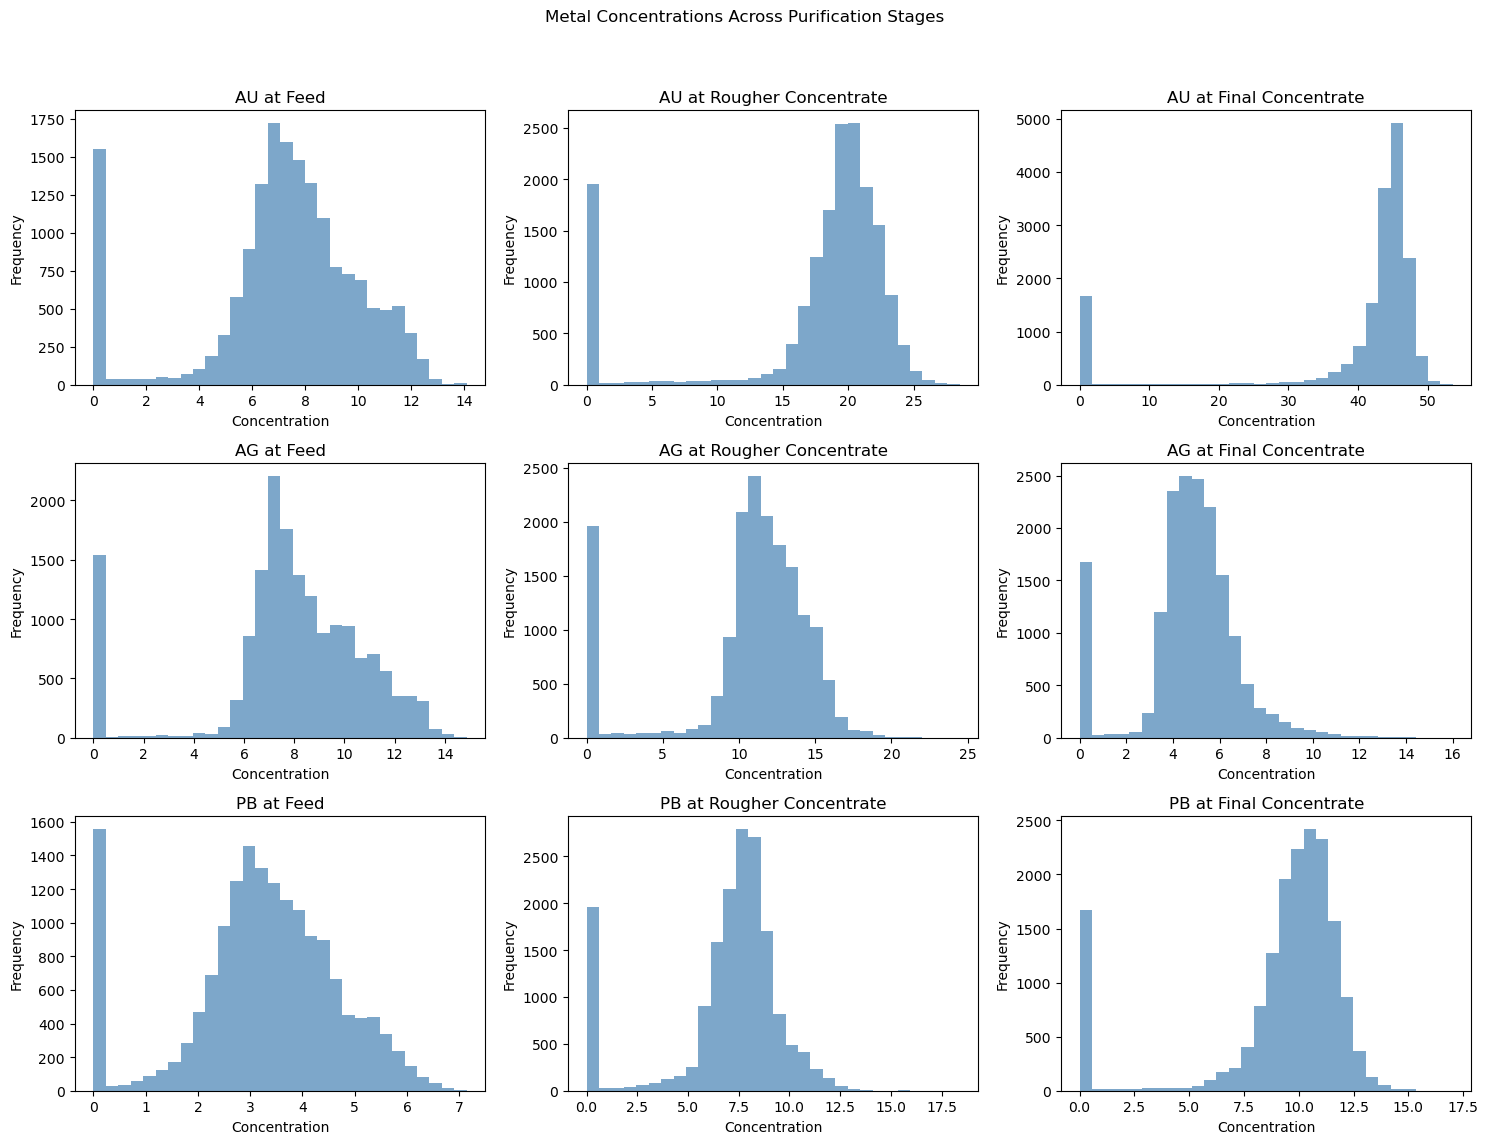

In [ ]:

import matplotlib.pyplot as plt

metals = ['au', 'ag', 'pb']

stages = {
    'feed': ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb'],
    'rougher_concentrate': ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb'],
    'final_concentrate': ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Metal Concentrations Across Purification Stages')

for i, metal in enumerate(metals):
    for j, (stage, cols) in enumerate(stages.items()):
        col = cols[i]
        if col in gold_recovery_train.columns:
            axes[i, j].hist(gold_recovery_train[col].dropna(), bins=30, color='steelblue', alpha=0.7)
            axes[i, j].set_title(f'{metal.upper()} at {stage.replace("_", " ").title()}')
            axes[i, j].set_xlabel('Concentration')
            axes[i, j].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
